In [1]:
#pip install keras
#pip install -U scikit-learn
#pip install pillow
#pip install matplotlib
#pip install jupyternotify
#unzip DR\ no\ aug
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

2023-03-31 15:44:33.591742: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Variables Being Used

In [3]:
#variables being used
batch_size=32
#val_split=0.2 #20 percent validation
image_size=224 
image_shape=(image_size,image_size)
#file_directory='/root/DR no aug'
#file_directory='/root/01DR_noDR'
train_file_directory='/root/train_val_split/Training'
validation_file_directory='/root/train_val_split/Validation'
alt_train_file_directory='/root/train_val_split/Training_no_weights'

## Importing Datasets

In [4]:

#from keras.applications.vgg16 import preprocess_input #for that vgg16
#import tensorflow as tf

from keras.applications.resnet_v2 import ResNet101V2, preprocess_input

training_datagen = ImageDataGenerator( 
        #preprocessing_function=preprocess_input, # use this only when using VGG16
        rescale=1./255,
        rotation_range=40,#can change this
        shear_range=0.2,#can change this
        zoom_range=0.2, #can change this
        horizontal_flip=True,
        fill_mode='wrap',# constant,reflect,wrap,
        )

validation_datagen=ImageDataGenerator(
    #preprocessing_function=preprocess_input,
    rescale=1./255    
        )

#Creating our generators, no need of changing values here
train_generator = training_datagen.flow_from_directory( #Creating our training generator 
        train_file_directory,  
        target_size=image_shape,
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='categorical',
        shuffle = False,
        )

validation_generator = validation_datagen.flow_from_directory( #Creating our validation generator
        validation_file_directory, 
        target_size=image_shape, 
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='categorical',
        shuffle = False,
)

Found 561 images belonging to 3 classes.
Found 50 images belonging to 3 classes.


## Displaying Images

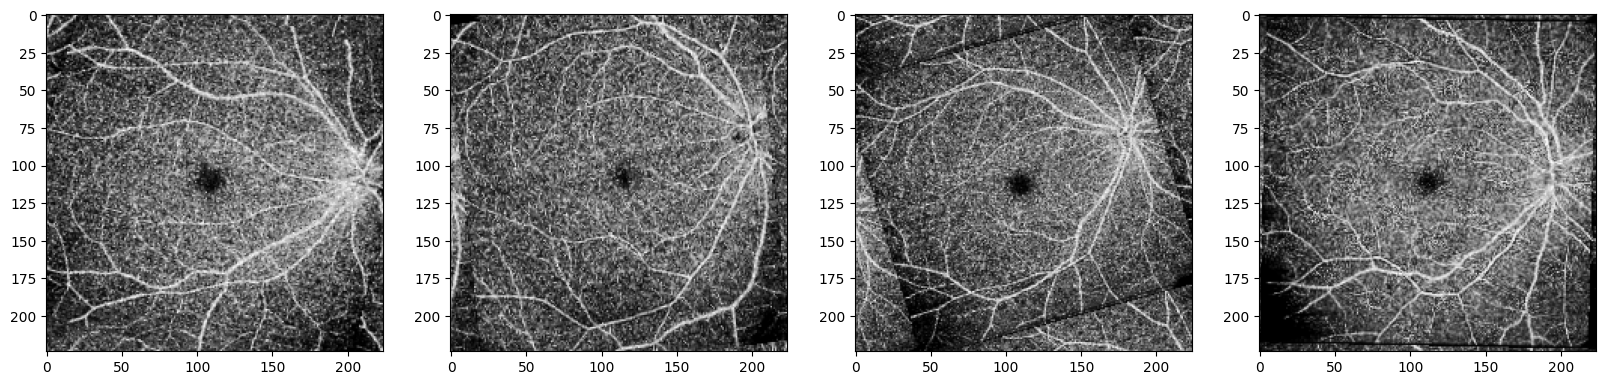

In [5]:
# Enable/Disable to see 4 random images
fig, axs=plt.subplots(ncols=4, figsize=(20,20))
for i in range(4):
  axs[i].imshow(train_generator[i][0][0], cmap='gray', vmin=0, vmax=1)
#axs[0].plt.show()

## Creating weights

In [6]:
import numpy as np ## Calculating the class weights
from sklearn.utils.class_weight import compute_class_weight

class_weighing = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights=dict(zip(np.unique(train_generator.classes), class_weighing))

print(class_weights)

{0: 0.6051779935275081, 1: 0.9739583333333334, 2: 3.1166666666666667}


## Creating Model

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras.optimizers import SGD


In [8]:
INPUT_SHAPE = (image_size, image_size, 3) 

base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
   layer.trainable = False

model.summary()

2023-03-31 15:44:38.931675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-03-31 15:44:38.936311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-03-31 15:44:38.936658: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

                                                                                                  
 average_pooling2d (AveragePool  (None, None, None,   0          ['max_pooling2d_1[0][0]']        
 ing2D)                         192)                                                              
                                                                                                  
 conv2d_5 (Conv2D)              (None, None, None,   12288       ['max_pooling2d_1[0][0]']        
                                64)                                                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, None, None,   76800       ['activation_6[0][0]']           
                                64)                                                               
                                                                                                  
 conv2d_10

                                                                                                  
 conv2d_18 (Conv2D)             (None, None, None,   16384       ['average_pooling2d_1[0][0]']    
                                64)                                                               
                                                                                                  
 batch_normalization_12 (BatchN  (None, None, None,   192        ['conv2d_12[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_normalization_14 (BatchN  (None, None, None,   192        ['conv2d_14[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_nor

                                                                                                  
 batch_normalization_25 (BatchN  (None, None, None,   192        ['conv2d_25[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 activation_19 (Activation)     (None, None, None,   0           ['batch_normalization_19[0][0]'] 
                                64)                                                               
                                                                                                  
 activation_21 (Activation)     (None, None, None,   0           ['batch_normalization_21[0][0]'] 
                                64)                                                               
                                                                                                  
 activatio

                                128)                                                              
                                                                                                  
 conv2d_36 (Conv2D)             (None, None, None,   114688      ['activation_35[0][0]']          
                                128)                                                              
                                                                                                  
 batch_normalization_31 (BatchN  (None, None, None,   384        ['conv2d_31[0][0]']              
 ormalization)                  128)                                                              
                                                                                                  
 batch_normalization_36 (BatchN  (None, None, None,   384        ['conv2d_36[0][0]']              
 ormalization)                  128)                                                              
          

 ormalization)                  160)                                                              
                                                                                                  
 activation_44 (Activation)     (None, None, None,   0           ['batch_normalization_44[0][0]'] 
                                160)                                                              
                                                                                                  
 conv2d_45 (Conv2D)             (None, None, None,   179200      ['activation_44[0][0]']          
                                160)                                                              
                                                                                                  
 batch_normalization_45 (BatchN  (None, None, None,   480        ['conv2d_45[0][0]']              
 ormalization)                  160)                                                              
          

 activation_48 (Activation)     (None, None, None,   0           ['batch_normalization_48[0][0]'] 
                                192)                                                              
                                                                                                  
 activation_49 (Activation)     (None, None, None,   0           ['batch_normalization_49[0][0]'] 
                                192)                                                              
                                                                                                  
 mixed5 (Concatenate)           (None, None, None,   0           ['activation_40[0][0]',          
                                768)                              'activation_43[0][0]',          
                                                                  'activation_48[0][0]',          
                                                                  'activation_49[0][0]']          
          

 batch_normalization_53 (BatchN  (None, None, None,   576        ['conv2d_53[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_58 (BatchN  (None, None, None,   576        ['conv2d_58[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_59 (BatchN  (None, None, None,   576        ['conv2d_59[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_50 (Activation)     (None, None, None,   0           ['batch_normalization_50[0][0]'] 
          

 conv2d_60 (Conv2D)             (None, None, None,   147456      ['mixed6[0][0]']                 
                                192)                                                              
                                                                                                  
 conv2d_63 (Conv2D)             (None, None, None,   258048      ['activation_62[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_68 (Conv2D)             (None, None, None,   258048      ['activation_67[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_69 (Conv2D)             (None, None, None,   147456      ['average_pooling2d_6[0][0]']    
          

 batch_normalization_71 (BatchN  (None, None, None,   960        ['conv2d_71[0][0]']              
 ormalization)                  320)                                                              
                                                                                                  
 batch_normalization_75 (BatchN  (None, None, None,   576        ['conv2d_75[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_71 (Activation)     (None, None, None,   0           ['batch_normalization_71[0][0]'] 
                                320)                                                              
                                                                                                  
 activation_75 (Activation)     (None, None, None,   0           ['batch_normalization_75[0][0]'] 
          

                                384)                                                              
                                                                                                  
 activation_79 (Activation)     (None, None, None,   0           ['batch_normalization_79[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_82 (Activation)     (None, None, None,   0           ['batch_normalization_82[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_83 (Activation)     (None, None, None,   0           ['batch_normalization_83[0][0]'] 
                                384)                                                              
          

 ormalization)                  384)                                                              
                                                                                                  
 batch_normalization_92 (BatchN  (None, None, None,   1152       ['conv2d_92[0][0]']              
 ormalization)                  384)                                                              
                                                                                                  
 conv2d_93 (Conv2D)             (None, None, None,   393216      ['average_pooling2d_8[0][0]']    
                                192)                                                              
                                                                                                  
 batch_normalization_85 (BatchN  (None, None, None,   960        ['conv2d_85[0][0]']              
 ormalization)                  320)                                                              
          

### Compile

In [9]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), #SGD or adam
              loss='categorical_crossentropy' ,
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Generating Callbacks

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath="/root/saved_models/{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint= ModelCheckpoint(filepath,monitor='val_accuracy',verbose=0,save_best_only=True,mode='max')
early_stop=EarlyStopping(monitor='val_accuracy',patience=30,verbose=0) #only change patience

callback_list=[checkpoint]#add the callbacks used

### Model.Fit()

In [11]:
%%notify
history=model.fit(
        train_generator,
        steps_per_epoch=len(train_generator.classes)//batch_size,
        verbose=1, 
        epochs=500,  #change this
        validation_data=validation_generator,
        validation_steps=len(validation_generator.classes)//batch_size,
        callbacks=callback_list,
        class_weight=class_weights #disable enable this
)
print("Done bro")

Epoch 1/500


2023-03-31 15:44:42.592192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-03-31 15:44:46.994277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-03-31 15:44:47.793434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


17/17 [==============================] - ETA: 0s - loss: 1.2451 - accuracy: 0.2420

2023-03-31 15:44:55.232957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


17/17 [==============================] - 15s 555ms/step - loss: 1.2451 - accuracy: 0.2420 - val_loss: 1.3458 - val_accuracy: 0.0312
Epoch 2/500
17/17 [==============================] - 10s 613ms/step - loss: 1.2051 - accuracy: 0.1645 - val_loss: 1.0815 - val_accuracy: 0.2500
Epoch 3/500
17/17 [==============================] - 10s 612ms/step - loss: 1.2366 - accuracy: 0.1304 - val_loss: 0.9705 - val_accuracy: 0.5625
Epoch 4/500
17/17 [==============================] - 10s 627ms/step - loss: 0.9870 - accuracy: 0.4405 - val_loss: 0.8097 - val_accuracy: 0.7188
Epoch 5/500
17/17 [==============================] - 11s 624ms/step - loss: 1.0192 - accuracy: 0.4835 - val_loss: 0.7691 - val_accuracy: 0.7812
Epoch 6/500
17/17 [==============================] - 10s 585ms/step - loss: 1.1595 - accuracy: 0.4083 - val_loss: 1.0351 - val_accuracy: 0.4375
Epoch 7/500
17/17 [==============================] - 10s 588ms/step - loss: 1.1408 - accuracy: 0.2798 - val_loss: 0.9955 - val_accuracy: 0.5000
Epoc

17/17 [==============================] - 10s 583ms/step - loss: 0.8014 - accuracy: 0.5992 - val_loss: 0.7118 - val_accuracy: 0.6875
Epoch 58/500
17/17 [==============================] - 10s 600ms/step - loss: 0.9265 - accuracy: 0.5142 - val_loss: 0.8071 - val_accuracy: 0.6562
Epoch 59/500
17/17 [==============================] - 10s 583ms/step - loss: 0.9208 - accuracy: 0.5198 - val_loss: 0.7370 - val_accuracy: 0.6875
Epoch 60/500
17/17 [==============================] - 10s 585ms/step - loss: 0.9001 - accuracy: 0.6125 - val_loss: 0.7273 - val_accuracy: 0.6875
Epoch 61/500
17/17 [==============================] - 10s 584ms/step - loss: 0.8879 - accuracy: 0.5652 - val_loss: 0.7481 - val_accuracy: 0.6562
Epoch 62/500
17/17 [==============================] - 10s 582ms/step - loss: 0.8883 - accuracy: 0.5312 - val_loss: 0.7663 - val_accuracy: 0.6875
Epoch 63/500
17/17 [==============================] - 10s 583ms/step - loss: 0.9174 - accuracy: 0.5104 - val_loss: 0.7482 - val_accuracy: 0.656

17/17 [==============================] - 10s 585ms/step - loss: 0.8341 - accuracy: 0.5614 - val_loss: 0.7353 - val_accuracy: 0.6562
Epoch 114/500
17/17 [==============================] - 10s 593ms/step - loss: 0.8966 - accuracy: 0.5992 - val_loss: 0.6732 - val_accuracy: 0.7188
Epoch 115/500
17/17 [==============================] - 10s 581ms/step - loss: 0.8417 - accuracy: 0.6314 - val_loss: 0.7209 - val_accuracy: 0.6875
Epoch 116/500
17/17 [==============================] - 10s 582ms/step - loss: 0.9639 - accuracy: 0.4972 - val_loss: 0.8133 - val_accuracy: 0.6875
Epoch 117/500
17/17 [==============================] - 10s 589ms/step - loss: 0.8472 - accuracy: 0.5558 - val_loss: 0.7146 - val_accuracy: 0.6562
Epoch 118/500
17/17 [==============================] - 10s 589ms/step - loss: 0.9783 - accuracy: 0.5766 - val_loss: 0.7728 - val_accuracy: 0.6875
Epoch 119/500
 3/17 [====>.........................] - ETA: 7s - loss: 0.9711 - accuracy: 0.3854

### Curves

In [12]:
#loss curve
fig, axs=plt.subplots(ncols=2,figsize=(15, 5))#, figsize=(20,20))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
axs[0].plot(epochs, loss, 'y', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set(title='Loss', xlabel='Epochs', ylabel='Epochs');

#accuracy curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
axs[1].plot(epochs, acc, 'y', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Epochs');

In [13]:
"""prediction_classes = np.array([])
true_classes =  np.array([])
i=0
for x, y in validation_generator:
    if i==len(validation_generator.classes):
        break    
    i=i+1
    prediction_classes = np.concatenate([prediction_classes,np.argmax(model.predict(x,verbose=0), axis = -1)])
    true_classes = np.concatenate([true_classes, np.argmax(y, axis=-1)])
print(classification_report(true_classes, prediction_classes))"""

In [14]:
#model.save('to_continue.h5')
#continue_model=load_model('to_continue.h5')

## Evaluating Model

In [15]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

#model = load_model('/root/44-0.82.hdf5')

In [16]:
#new_model=load_model(".hdf5")

In [17]:
data_eval=validation_generator
model_eval=model
results=model_eval.evaluate_generator(data_eval, steps=len(data_eval.classes)//batch_size)
print("Loss and accuracy are", results)
Y_pred = model_eval.predict_generator(data_eval, steps=len(data_eval.classes)//batch_size+1)
#print(train_generator.classes)
y_pred = np.argmax(Y_pred, axis=1)
#print(train_generator.classes)
#print(y_pred)
#print(X)
        
print('Confusion Matrix')
cm=confusion_matrix(data_eval.classes,y_pred)
target_names = ['NoDR', 'mildDR','seriousDR']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Classification Report')

print(classification_report(data_eval.classes,y_pred, target_names=target_names))